# Cits4403 - Project

The simulation in this project aims to find out how epdidemic behaves in different scnerios.

## Setup

In [543]:
import numpy as np
import matplotlib.pyplot as plt

from os.path import basename, exists

# Download the base code provided that would be used by the simulation
# Retrieved from workshop exercises 7
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

## Epidemic Simulation

In [551]:
from Cell2D import Cell2D, draw_array
from scipy.signal import correlate2d
from enum import Enum
from matplotlib import colors
from utils import three_frame, savefig

# Retrieved from workshop exercises 7
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

class Status(Enum):
    """ Represents the current status of a agent """

    HEALTHY=1
    INFECTED_LATENT=2
    INFECTED_ACTIVE=3
    DEAD=4

# The class for each agent or people in the simulation.
# Some parts are written with intuition from ChatGPT, such as idea of creating 
# a epidemic curve.
class Agent():
    """ An agent in the simulation."""

    # The base infection resistance of agent
    def __init__(self, loc, infec_resist_low=0.3, isLockDown=False):
        # The position of the agent in the grid
        self.loc = tuple(loc)

        # The lowest resistance defines the immune system of a agent, different 
        # agent have different immunities
        self.infec_resist_low = np.random.uniform(0, infec_resist_low)

        # The resistance of the agent to the infection
        self.infec_resist = self.infec_resist_low

        # Represent of the agent is in lock down
        self.isLockDown = isLockDown

        # Represent infection condition of agent
        self.status = Status.HEALTHY

        # Array storing the number of days where agent gets infected latent and
        # active
        self.infec_latent_day = []
        self.infec_active_day = []

    def getLoc(self):
        """Return the agent's location"""

        return self.loc
    
    def infect(self, step_num):
        """Infect the agent"""

        self.status = Status.INFECTED_LATENT
        self.infec_latent_day.append(step_num)

    def step(self, sim, infec_prob):
        """ The agent performs a step, which updates its information """

        if self.status == Status.INFECTED_LATENT:
            # Infected latent agent becomes active
            if sim.step_num - self.infec_latent_day[-1] >= sim.latent_period:
                self.status = Status.INFECTED_ACTIVE
                self.infec_active_day.append(sim.step_num)
        elif self.status == Status.INFECTED_ACTIVE:
            # A agent with a better immune system will recover faster
            if sim.step_num - self.infec_active_day[-1] >=\
            sim.recovery_period * (1 - self.infec_resist * 0.5):
                self.status = Status.HEALTHY
                self.infec_resist += sim.recovery_bonus
            # The active infection damages the agent as well, so every day/step 
            # there is chance of dying 
            elif np.random.uniform() < sim.fatal_rate:
                self.status = Status.DEAD
        elif self.status == Status.HEALTHY:
            # The agent can become infected based on the infec_prob, which is 
            # accumulative probability of infection based on neighborhood. A 
            # stronger immune system or infection reistence would also reduce 
            # the probability
            # If agent is lock down then another level of separation is applied 
            # hence the probability of getting infected is even lower
            infec_prob_mod = infec_prob * (1 - self.infec_resist)
            infec_prob_mod = infec_prob_mod * (1 - sim.lock_down_resist) if \
                            self.isLockDown else infec_prob_mod
            if np.random.uniform() < infec_prob_mod:
                self.infect(sim.step_num)
        
        # Agent may had a boost in immune system against the infection and 
        # decreases overtime until threadhold of the agent
        self.infec_resist = max(self.infec_resist_low, self.infec_resist -\
                                 sim.infec_resist_dec)

# Class represent the simulation of the epidemic in a town
class EpidemicSim(Cell2D):
    """Represent a epidemic simulation in a small town"""

    options = dict(mode='same', boundary='fill')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)

    def __init__(self, n, pop, infec_prob=0.2, latent_period=7, fatal_rate=0.003,
                  recovery_period=10, infec_resist_dec=0.015, recovery_bonus=0.8,
                   agent_move_size=2, lock_down_resist=0.3, num_infect=100):
        # The grid size representing the size of the town
        self.n = n

        # The population, define to be max of half of the cells.
        self.pop = min(pop, int(n*n/2))

        # Defines how easy it is for the infections to spread
        self.infec_prob = infec_prob

        # Defines how long it takes for agent to be come infectious
        self.latent_period = latent_period

        # Defines how long it takes for agent to recover
        self.recovery_period = recovery_period

        # Defines how much the infection resistance for the agent decays over 
        # time. This is from the immune system after agent recovers
        self.infec_resist_dec = infec_resist_dec
        
        # The probability of a infected agent dying in a day
        self.fatal_rate = fatal_rate

        # The number of step currently
        self.step_num = 0
        
        # When agents recover, they become more resistent to the infection
        self.recovery_bonus = recovery_bonus

        # How far the agent can move in a square, 1 means agent have 8 possible 
        # spaces to move to each time step
        self.agent_move_size = agent_move_size
        move_grid_size = 1 + agent_move_size * 2

        # Contains the locations agent can move to if agent is at loc (0,0)
        self.origin_mov_locs = [(i[0] - agent_move_size, i[1] - agent_move_size)
                                 for i in make_locs(move_grid_size, move_grid_size)]
        
        # Means how much resistance against the infection if a person is in 
        # lockdown. This means they stay at home not moving and other may visit 
        # them an get them infected, but at much lower rate.
        self.lock_down_resist = lock_down_resist

        # Just used for drawing
        self.array = np.zeros((n,n))

        # To store accumlated agent status data over time
        self.healthy_counts = []
        self.infec_counts = []
        self.fatal_counts = []
        self.infec_ratios = []

        # Create the agents
        self.make_agents()

        # Infect some agents
        self.apply_infection(n=num_infect)

    def getAgentsByStatus(self, status):
        """ Get all alive agents """

        return [agent for agent in self.agents if agent.status == status]

    def getAliveAgents(self):
        """ Get all alive agents """

        return [agent for agent in self.agents if agent.status != Status.DEAD]
    
    def getMoveableAgents(self):
        """Get all agents that can move"""

        return [agent for agent in self.agents if agent.status != Status.DEAD and not agent.isLockDown]
    
    def getInfectedAgents(self):
        """ Get all infected agents """

        return [agent for agent in self.agents if agent.status == 
                Status.INFECTED_LATENT or agent.status == Status.INFECTED_ACTIVE]

    def getAgentMoveableLoc(self, agent, agent_locs):
        """Find a new random location that the agent can move to"""

        # Find out positions the agent can move to
        agent_x = agent.loc[0]
        agent_y = agent.loc[1]
        # Shift of all the origin moveable locs baed on the agent loc
        agent_move_locs = [(loc[0] + agent_x, loc[1] + agent_y)
                            for loc in self.origin_mov_locs]
        # Agent will move randomly
        np.random.shuffle(agent_move_locs)
        # Location should not clash with other agents
        for loc in agent_move_locs:
            if loc[0] < self.n and loc[1] < self.n and loc[0] >= 0 \
                and loc[1] >= 0 and loc not in agent_locs:
                return loc
        return None
    
    def recordData(self):
        """Updated the accumlated agents data over time"""

        # Count the agent in different status and store them
        h_count = 0
        i_count = 0
        f_count = 0
        for agent in self.agents:
            if agent.status == Status.HEALTHY:
                h_count += 1
            elif agent.status == Status.INFECTED_ACTIVE or \
                agent.status == Status.INFECTED_LATENT:
                i_count += 1
            elif agent.status == Status.DEAD:
                f_count += 1

        self.healthy_counts.append(h_count)
        self.infec_counts.append(i_count)
        self.fatal_counts.append(f_count)
        self.infec_ratios.append(i_count / (h_count + i_count))

    def step(self):
        """Executes one time step, representing one day"""
        
        # A new day
        self.step_num += 1
        infected_agents = self.getAgentsByStatus(Status.INFECTED_ACTIVE)
        # Get 2d cell of the 
        cells_infec_probs = np.zeros((self.n, self.n))
        # Find the infected agents to create a 2d grid of probabilities. This 
        # is then used to apply rule to find the probability of each cell 
        # getting infected.
        for agent in infected_agents:
            cells_infec_probs[agent.loc] = self.infec_prob
        cells_infec_probs_corr = correlate2d(cells_infec_probs, self.kernel,
                                             **self.options)
        # Each agent will update every step with the corresponding probabilities
        #  of infection passed
        for agent in self.agents:
            agent.step(self, cells_infec_probs_corr[agent.loc])
        agent_locs = [agent.loc for agent in self.agents]
        # Move the agent
        for agent in self.getMoveableAgents():
            new_loc = self.getAgentMoveableLoc(agent, agent_locs)
            # None means agent has no place to move
            if new_loc is not None:
                # Update agent locations
                agent_locs.remove(agent.loc)
                agent_locs.append(new_loc)
                agent.loc = new_loc

        # Record the agents status data     
        self.recordData()

    def apply_vaccine(self, p=0.6, vaccine_effect=0.7):
        """Pretend agents took vaccine, by improving the infection resistance of
            agents in the simulation by probability of p"""
        
        # Agent will have improved infection resistance
        for agent in self.agents:
            if np.random.uniform() < p:
                agent.infec_resist += vaccine_effect

    def apply_lockdown(self, p=0.6):
        """Apply lockdown to agents based on p as the probability"""

        for agent in self.agents:
            if np.random.uniform() < p:
                agent.isLockDown = True

    def apply_infection(self, n=100):
        """Try make n number of the agents infected active"""

        # Not exactly n number are infected, one could be set as infected more 
        # than once
        actual_n = min(n, len(self.agents))
        for i in range(actual_n):
            agent = np.random.choice(self.agents)
            agent.infect(0)

    def make_agents(self):
        """Create agents in the simulation"""

        # Location of the agents is genereted randomly, the method is learnt
        # from the workshop exercises 7
        locs = make_locs(self.n, self.n)
        np.random.shuffle(locs)

        # Generated pop field nubmer of agents each taking the random shuffled
        # locations created
        self.agents = [Agent(locs[i]) for i in range(self.pop)]
        
    # Retrieved from the workshop exercises 7
    def draw(self):
        """Draws the cells."""

        # fig = plt.figure()
        # ax = fig.add_subplot()
        # ax.text(0, self.n + 2, f"step={self.step_num}", fontsize=8)
        # For plotting the agnet status
        self.array = np.zeros((self.n, self.n))
        for agent in self.agents:
            self.array[agent.loc] = agent.status.value

        # Settings for the plot, empty cells is white, healthy ids green,
        # orange is latent, red is active and black is dead
        cmap = colors.ListedColormap(["white", "green", "orange", "red", "black"])
        norm = colors.BoundaryNorm([0,1,2,3,4,5], cmap.N)
        plt.axis([0, self.n, 0, self.n])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(self.array, cmap=cmap, norm=norm)

    def draw_data(self, save_name=None):
        """Draw the data accumulated over time steps"""
        
        # Plotting instructions leartn from ChatGPT
        days = list(range(self.step_num))

        plt.clf()
        plt.figure(figsize=(5, 3))
        print(self.step_num)
        plt.plot(days, self.healthy_counts, label="Healthy")
        plt.plot(days, self.infec_counts, label="Infected")
        plt.plot(days, self.fatal_counts, label="Dead")
        plt.xlabel("Days")
        plt.ylabel("Count")
        plt.title("Epidemic Curve")
        plt.legend()

        if save_name != None:
            plt.savefig(save_name, bbox_inches="tight")

        plt.show()

    # Retrieved from the workshop exercises 7
    def get_coords(self, status=Status.HEALTHY):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        filtered_agents = [agent.getLoc() for agent in agents if agent.status == status]
        if len(filtered_agents) == 0:
            return [], []
        rows, cols = np.transpose(filtered_agents)
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

## Running the simulation

Visualisation of initial configuration

Saving figure to file figs/init.png


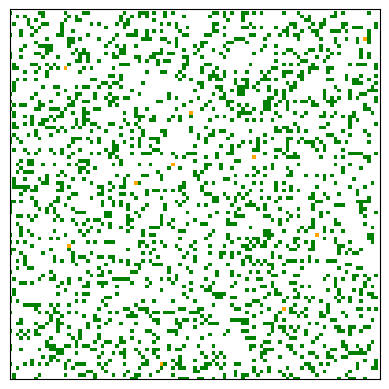

In [545]:
# Directory to store figures
!mkdir figs

np.random.seed(12345678)
sim = EpidemicSim(n=100, infec_prob=0.2, pop=2000, num_infect=10)
sim.draw()
savefig("figs/init.png", bbox_inches="tight")


A estimate view of the spatial view of the epidemic in three time steps, start, half year and a year.

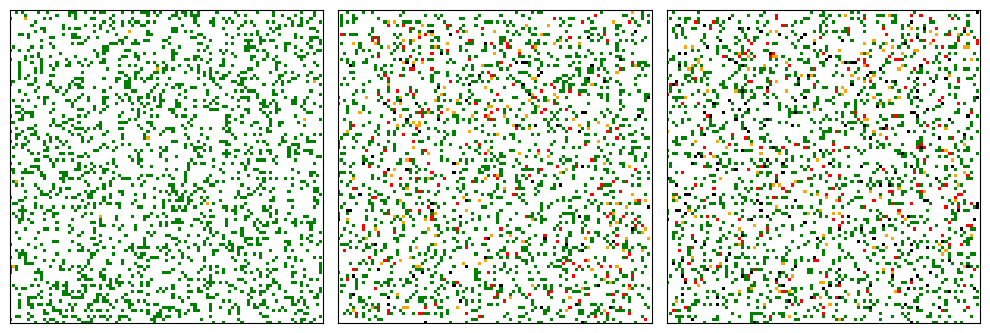

In [546]:
sim = EpidemicSim(n=100, infec_prob=0.2, pop=2000, num_infect=10)
three_frame(sim, [0, 180, 180])

Spatial view and epidemic curve of simulation after a year.

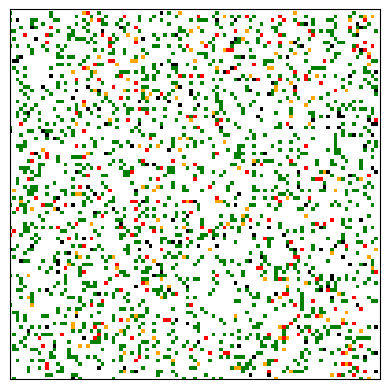

Saving figure to file figs/norm_spatial_365.png
364


<Figure size 640x480 with 0 Axes>

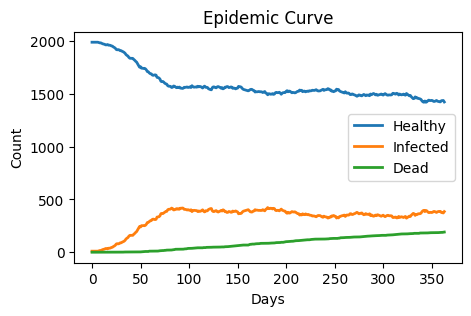

In [547]:
sim = EpidemicSim(n=100, infec_prob=0.2, pop=2000, num_infect=10)
sim.animate(365)
sim.draw()
savefig("figs/norm_spatial_365.png", bbox_inches="tight")
sim.draw_data(save_name="figs/norm_epidemic_curve_365.png")

Simulation with same parameters but vaccine applied. The vaccine will be applied randomly on 70 percent of the population and the effectiveness of the vaccine is prventing 95 percent of the infections.

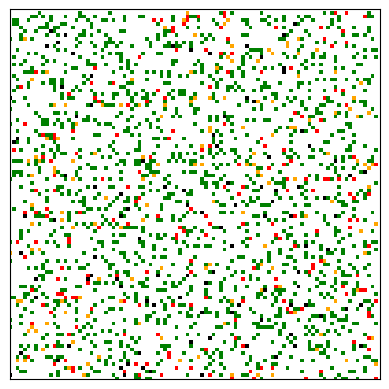

Saving figure to file figs/vaccine_spatial_365.png
364


<Figure size 640x480 with 0 Axes>

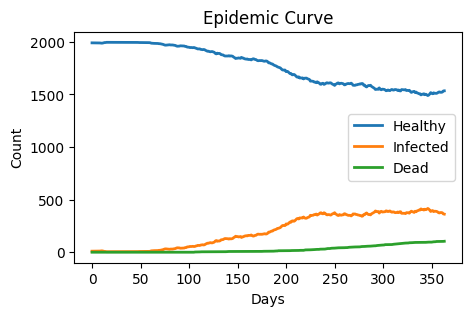

In [548]:
sim = EpidemicSim(n=100, infec_prob=0.2, pop=2000, num_infect=10)
sim.apply_vaccine(p=0.7, vaccine_effect=0.95)
sim.animate(365)
sim.draw()
savefig("figs/vaccine_spatial_365.png", bbox_inches="tight")
sim.draw_data(save_name="figs/vaccine_epidemic_curve_365.png")

Simulation with same parameter, but lockdown applied to the agents.

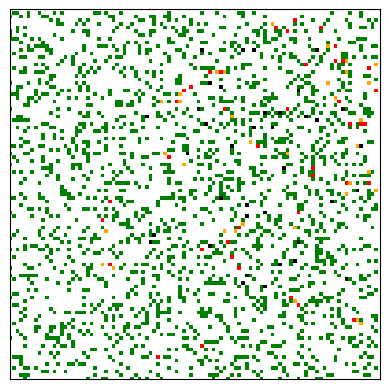

Saving figure to file figs/lockdown_spatial_365.png
364


<Figure size 640x480 with 0 Axes>

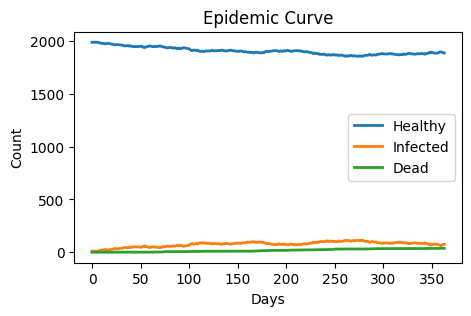

In [549]:
sim = EpidemicSim(n=100, infec_prob=0.2, pop=2000, num_infect=10)
sim.apply_lockdown(p=0.7)
sim.animate(365)
sim.draw()
savefig("figs/lockdown_spatial_365.png", bbox_inches="tight")
fig = sim.draw_data(save_name="figs/lockdown_epidemic_curve_365.png")

For similar parameters, find the trend on the influence of density by running the simulation on a range of differnt populations.

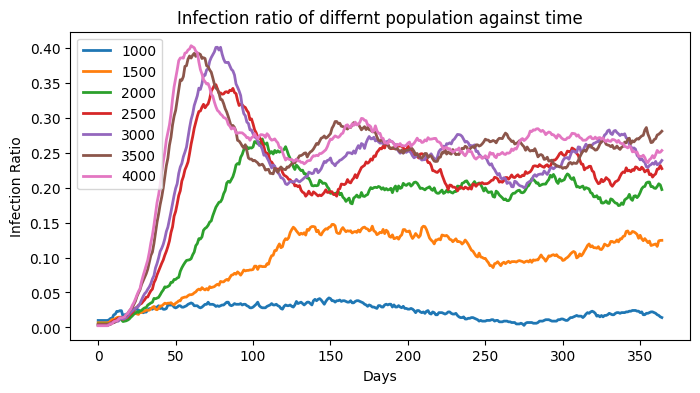

In [550]:
pops = [1000,1500,2000,2500,3000,3500,4000]

plt.figure(figsize=(8,4))
days = list(range(365))
for pop in pops:
    sim = EpidemicSim(n=100, infec_prob=0.2, pop=pop, num_infect=10)
    for i in range(365):
        sim.step()
    # infec_ratios = [i / pop for i in sim.infec_counts]
    plt.plot(days, sim.infec_ratios, label=str(pop))
plt.xlabel("Days")
plt.ylabel("Infection Ratio")
plt.title("Infection ratio of differnt population against time")
plt.legend()
plt.savefig("figs/density_trend.png", bbox_inches="tight")
plt.show()
